In [3]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# force GPU device
# os.environ["CUDA_VISIBLE_DEVICES"]='0'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from keras import Sequential, Input

load data from csv

In [4]:
max_sequence_length = 100

In [5]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences/'

data = []

labels = None
no_labels = None

distinct_features = [
'EVENT_ACCEPT', 'EVENT_BIND', 'EVENT_CHANGE_PRINCIPAL', 'EVENT_CLOSE', 'EVENT_CONNECT', 'EVENT_CREATE_OBJECT', 'EVENT_EXECUTE', 'EVENT_EXIT', 'EVENT_FCNTL', 'EVENT_FORK', 'EVENT_LINK', 'EVENT_LOGIN', 'EVENT_LSEEK', 'EVENT_MMAP', 'EVENT_MODIFY_FILE_ATTRIBUTES', 'EVENT_MODIFY_PROCESS', 'EVENT_MPROTECT', 'EVENT_OPEN', 'EVENT_OTHER', 'EVENT_READ', 'EVENT_RECVFROM', 'EVENT_RECVMSG', 'EVENT_RENAME', 'EVENT_SENDMSG', 'EVENT_SENDTO', 'EVENT_SIGNAL', 'EVENT_TRUNCATE', 'EVENT_UNLINK', 'EVENT_WRITE', 
]
distinct_features = [ x[6:] for x in distinct_features ]
no_features = len(distinct_features)

count = 0
count_long_sequences_splitted = 0
count_long_sequences_splitted_result = 0
for file_name in os.listdir(data_directory):
    count += 1
    if count % 50000 == 0:
        print(f'Loaded {count} sequences')
    with open(data_directory + file_name, 'r') as f:
        label = file_name.split('_')[0]
        # build dictionary with counts of events
        lines = f.readlines()
        # if sequence is longer than max_sequence_length, split into multiple sequences
        if len(lines) > max_sequence_length:
            count_long_sequences_splitted += 1
            for i in range(0, len(lines), max_sequence_length):
                count_long_sequences_splitted_result += 1
                datapoints = []
                for event in lines[i:i+max_sequence_length]:
                    event = event.strip()
                    datapoints.append(distinct_features.index(event))
                data.append((label, datapoints))
        else:
            datapoints = []
            for event in lines:
                event = event.strip()
                datapoints.append(distinct_features.index(event))
            data.append((label, datapoints))

        """
        datapoints = []
        for event in f:
            event = event.strip()
            datapoints.append(distinct_features.index(event))
        if not len(datapoints) > max_sequence_length:
            data.append((label, datapoints))
        """

print(f'Loaded {len(data)} sequences')
print(f'Found {count_long_sequences_splitted} sequences longer than max_sequence_length ({max_sequence_length})')
print(f'Split them into {count_long_sequences_splitted_result} sequences')

print(f'Filtered out datapoints with less than 10 occurrences')
print(f'Left with {len(data)} datapoints')

random.shuffle(data)
labels = [ x[0] for x in data ]
data = [ x[1] for x in data ]

Loaded 50000 sequences
Loaded 100000 sequences
Loaded 150000 sequences
Loaded 200000 sequences
Loaded 250000 sequences
Loaded 300000 sequences
Loaded 350000 sequences
Loaded 400000 sequences
Loaded 756925 sequences
Found 50060 sequences longer than max_sequence_length (100)
Split them into 376122 sequences
Filtered out datapoints with less than 10 occurrences
Left with 756925 datapoints


In [6]:
distinct_labels = np.unique(np.array(labels))
no_labels = len(distinct_labels)
print(f'Found {no_labels} distinct labels')

# get distinct features
print(f'Found {no_features} distinct features')

# encode labels from strings to integers to one-hot
# labels = np.eye(no_labels)[np.vectorize(distinct_labels.tolist().index)(labels)]
# encode labels to integers
labels = np.vectorize(distinct_labels.tolist().index)(labels)
print(f'Encoded labels to integers')
# encode labels to one-hot
labels = np.eye(no_labels)[labels]
print(f'Encoded labels to one-hot')

# encode sequences from list of integers to list of one-hot
data = [ np.eye(no_features)[x] for x in data ]
print(f'Encoded sequences to one-hot')

# get pad event to pad sequences with when batches are built
pad_event = np.zeros(no_features)

Found 135 distinct labels
Found 29 distinct features
Encoded labels to integers
Encoded labels to one-hot
Encoded sequences to one-hot


In [7]:
print(f'data length: {len(data)}')
print(f'labels shape: {labels.shape}')

data length: 756925
labels shape: (756925, 135)


prepare data + generator

In [8]:
# split data into training and validation
split = int(len(data) * 0.8)

X_train = data[:split]
y_train = np.array(labels[:split])

X_val = data[split:]
y_val = np.array(labels[split:])

print(f'Training on {len(X_train)} samples')
print(f'Validating on {len(X_val)} samples')

Training on 605540 samples
Validating on 151385 samples


In [9]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, fixed_length, **kwargs):
        # valid **kwargs: workers, use_multiprocessing, max_queue_size
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.fixed_length = fixed_length
        self.no_samples = len(X)
        self.no_batches = int(np.ceil(self.no_samples / self.batch_size))

    def __len__(self):
        return self.no_batches

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, self.no_samples)

        # Get the batch data
        X_batch = self.X[start:end]
        y_batch = self.y[start:end]

        # Pad or truncate each sequence in X_batch to the fixed length
        X_batch_fixed = [self._pad_or_truncate(x, self.fixed_length) for x in X_batch]

        # Convert to numpy arrays
        X_batch_fixed = np.array(X_batch_fixed)
        y_batch = np.array(y_batch)

        return X_batch_fixed, y_batch

    def _pad_or_truncate(self, sequence, length):
        if len(sequence) < length:
            # Pad sequence with zeros to the fixed length
            return np.pad(sequence, ((0, length - len(sequence)), (0, 0)), mode='constant', constant_values=0)
        else:
            # Truncate sequence to the fixed length
            return sequence[:length]

    def on_epoch_end(self):
        pass

build model

In [10]:
model = Sequential(layers=[
    Input(shape=(None, no_features)),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(64, return_sequences=False),
    Dense(no_labels, activation='softmax')
])

model.summary()

2024-06-13 12:48:25.750340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-06-13 12:48:25.751020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9658 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 64)       │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 135)            │         8,775 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,303 (122.28 KB)

 Trainable params: 31,303 (122.28 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto'
)

checkpoint_path = ("/home/jrosendahl/sync/models/checkpoints")
model_checkpoint = ModelCheckpoint(
    filepath=f'{checkpoint_path}/rnn.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-7
)

csv_logger = CSVLogger(
    filename=f'{checkpoint_path}/rnn.log',
    append=True
)

optimizer = Adam(learning_rate=0.0001)


# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(optimizer=optimizer, loss='categorical_focal_crossentropy', metrics=['accuracy'])

train model

In [12]:
# load old model
# model = load_model(f'{checkpoint_path}/rnn.keras')

In [13]:
history = model.fit(
    x=Generator(X_train, y_train, 64, 1000),
    validation_data=Generator(X_val, y_val, 32, 1000),
    epochs=50,
    callbacks=[early_stop, model_checkpoint, lr_schedule, csv_logger],
)

# save history to file
with open(f'{checkpoint_path}/rnn_history.npy', 'wb') as f:
    np.save(f, history.history)

Epoch 1/50


I0000 00:00:1718275747.875184  537918 service.cc:145] XLA service 0x434cc50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718275747.875256  537918 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1718275747.875269  537918 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-06-13 12:49:07.957097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-13 12:49:08.230379: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1718275749.305408  537918 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9462/9462 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8088 - loss: 0.1318
Epoch 1: val_loss improved from inf to 0.08278, saving model to /home/jrosendahl/sync/models/checkpoints/rnn.keras
9462/9462 ━━━━━━━━━━━━━━━━━━━━ 2120s 224ms/step - accuracy: 0.8088 - loss: 0.1318 - val_accuracy: 0.8665 - val_loss: 0.0828 - learning_rate: 1.0000e-04
Epoch 2/50
9462/9462 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8490 - loss: 0.0949
Epoch 2: val_loss did not improve from 0.08278
9462/9462 ━━━━━━━━━━━━━━━━━━━━ 2115s 224ms/step - accuracy: 0.8490 - loss: 0.0949 - val_accuracy: 0.7585 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 3/50
  99/9462 ━━━━━━━━━━━━━━━━━━━━ 29:54 192ms/step - accuracy: 0.7681 - loss: 0.1487

KeyboardInterrupt: 

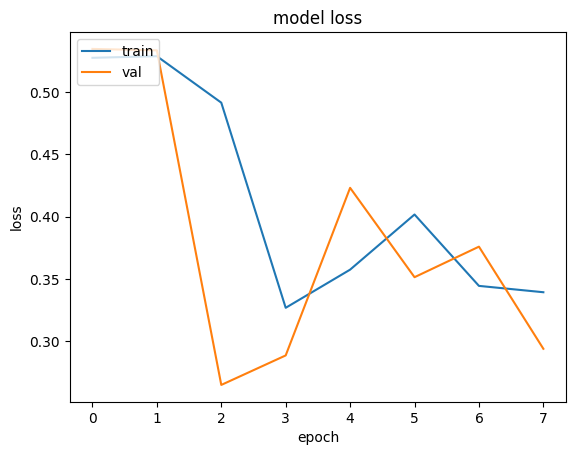

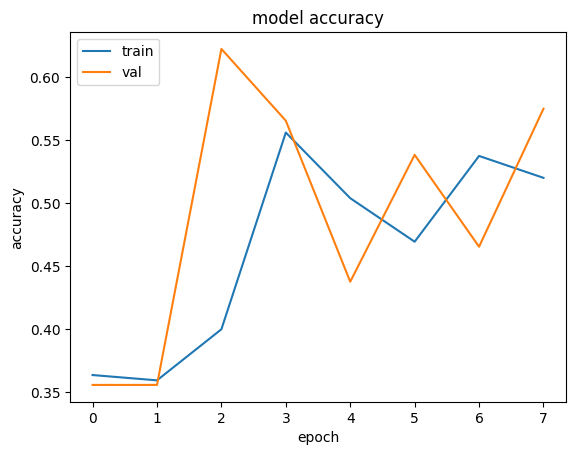

In [9]:
# plot history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()